In [33]:
import numpy as np
import pandas as pd
import hvplot.pandas
from utils.basics import get_sbj_scan_list
from utils.SNYCQ_NMF_Extra import cluster_scans, plot_W_scatter, plot_P
q_order = ['Future', 'Specific', 'Past', 'Positive', 'People', 'Images', 'Words', 'Negative', 'Surroundings', 'Myself', 'Intrusive']
import panel as pn

This notebook looks at the scenario where confounds are being modeled during the NMF of the experiential data.

MLT tells me that the optimal set of parameters are:

* Number of Dimensions: $D = 2$ 

* Regularization for the W matrix: $\beta_{W} = 0$ 

* Regularization for the Q matrix: $\beta_{Q} = 0.01 $

1. Load scan and subject list

In [2]:
sbj_list, scan_list, snycq = get_sbj_scan_list(when='post_motion')

++ [post_motion] Number of subjects: 133 subjects
++ [post_motion] Number of scans:    471 scans


In [3]:
snycq = snycq.drop('Vigilance', axis=1)

2. Load downloaded demographics information (per subject)

In [4]:
path = '../../../data/snycq/participants_post_motion_QA.csv'
demographics_per_subject = pd.read_csv(path, index_col=['Subject'])

3. Populate a new dataframe with demographics information on a scan-by-scan basis

In [5]:
demographics_per_scan = pd.DataFrame(index=pd.MultiIndex.from_tuples(scan_list, names=['Subject','Run']), columns=demographics_per_subject.columns)

In [6]:
for sbj in demographics_per_subject.index:
    demographics_per_scan.loc[sbj,'gender']            = demographics_per_subject.loc[sbj,'gender']
    demographics_per_scan.loc[sbj,'age (5-year bins)'] = demographics_per_subject.loc[sbj,'age (5-year bins)']

In [7]:
demographics_per_scan['age (5-year bins)'].value_counts()

25-30    217
20-25    185
30-35     42
40-45     12
35-40     10
45-50      4
60-65      1
Name: age (5-year bins), dtype: int64

In [8]:
demographics_per_scan['gender'].value_counts()

M    255
F    216
Name: gender, dtype: int64

***
## Load results from Ka-Chun

In [9]:
path = '../resources/mtl_snycq/factorization_fulldata_confounds.npz'
data = np.load(path)

The original factorization (no confounds approach) was: $$M = W \cdot Q'$$

Now, when we consider confounds, we have a different formulation:

$$ M = [W,C] \cdot [Q,Q_c]' $$

In [10]:
assert np.equal(snycq.values,data['M']).sum() == snycq.shape[0]* snycq.shape[1],"Shape of data disagrees across datasets"
assert list(data['subjlist']) == list(snycq.index.get_level_values('Subject')),"Subject order disagrees across datasets"
assert list(data['runlist']) == list(snycq.index.get_level_values('Run')), "Scan order disagrees across datasets"

In [11]:
W = pd.DataFrame(data['W'], columns=['Factor 1','Factor 2'], index=demographics_per_scan.index)
print(W.shape)

(471, 2)


In [12]:
C = pd.DataFrame(data['C'], columns=['Age (elder)','Gender (male)','Age (younger)','Gender (Female)','Intercept'], index=demographics_per_scan.index)
print(C.shape)

(471, 5)


In [13]:
Q = pd.DataFrame(data['Q'], columns=['Factor 1','Factor 2'], index=snycq.columns)
print(Q.shape)

(11, 2)


In [14]:
Qc = pd.DataFrame(data['Qc'], columns=C.columns, index=snycq.columns)
print(Qc.shape)

(11, 5)


In [15]:
M = pd.DataFrame(data['M'],index=snycq.index,columns=snycq.columns)
print(M.shape)

(471, 11)


Understanding how the C matrix is organized

In [16]:
pn.Row(pn.pane.DataFrame(C.iloc[100:110],width=1500),pn.pane.DataFrame(demographics_per_scan.iloc[100:110],width=800))

Row
    [0] DataFrame(DataFrame, width=1500)
    [1] DataFrame(DataFrame, width=800)

In [17]:
pn.Row(demographics_per_scan['age (5-year bins)'].sort_values().value_counts(sort=False),C['Age (elder)'].sort_values().value_counts(sort=False), C['Age (younger)'].sort_values(ascending=False).value_counts(sort=False))

Row
    [0] DataFrame(Series)
    [1] DataFrame(Series)
    [2] DataFrame(Series)

Exploring the Qc matrix

In [18]:
Qc[['Age (elder)','Age (younger)','Gender (male)','Gender (Female)','Intercept']].T.hvplot.heatmap(width=500, height=200).opts(xrotation=90)

:HeatMap   [columns,index]   (value)

In [19]:
W.hvplot.scatter(x='Factor 1', y='Factor 2', aspect='square')

:Scatter   [Factor 1]   (Factor 2)

In [20]:
N_CLUSTERS = 3
cluster_ids = cluster_scans(W, n_clusters=N_CLUSTERS)
cluster_ids = cluster_ids.astype(int)
print('++ INFO: Number of clusters = %d' % int(cluster_ids.max()+1))

++ INFO [cluster_scans]: Doing agglomerative clustering for provied k = 3
++ INFO: Number of clusters = 3


In [21]:
clusters_info = pd.DataFrame(index=W.index, columns=['Cluster ID','Cluster Label'])
clusters_info['Cluster ID'] = cluster_ids

In [22]:
cluster_labels_translate = {x:'Middle' for x in np.unique(cluster_ids)}
Waux = W.copy()
Waux['Cluster ID']    = cluster_ids
cluster_labels_translate[float(Waux.groupby('Cluster ID').mean().sort_values(by='Factor 1', ascending=False).iloc[0].name)] = 'Large F1'
cluster_labels_translate[float(Waux.groupby('Cluster ID').mean().sort_values(by='Factor 2', ascending=False).iloc[0].name)] = 'Large F2'
clusters_info['Cluster Label'] = [cluster_labels_translate[c] for c in Waux['Cluster ID']]
clusters_info['Cluster ID'] = 0
clusters_info.loc[clusters_info['Cluster Label']=='Large F1','Cluster ID'] = 1
clusters_info.loc[clusters_info['Cluster Label']=='Large F2','Cluster ID'] = 2
clusters_info.loc[clusters_info['Cluster Label']=='Middle'  ,'Cluster ID'] = 3
del Waux, cluster_ids, cluster_labels_translate

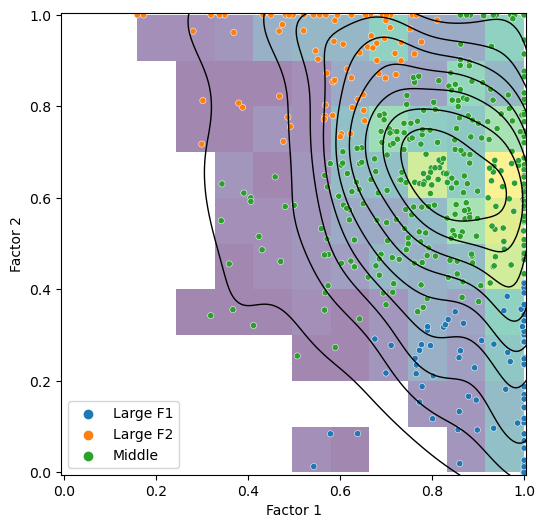

In [23]:
plot_W_scatter(W, clusters_info=clusters_info, plot_kde=True, plot_hist=True, marker_size=20)

In [24]:
clusters_info.value_counts('Cluster Label')

Cluster Label
Middle      312
Large F1     81
Large F2     78
dtype: int64

In [27]:
sort_clf1f2_list = []
for cl_label in ['Large F1','Large F2','Middle']:
    aux = pd.concat([W,clusters_info],axis=1)
    aux = aux.reset_index().set_index('Cluster Label').loc[cl_label]
    sort_clf1f2_list = sort_clf1f2_list + list(aux.sort_values(by=['Factor 1','Factor 2']).set_index(['Subject','Run']).index)
sort_clf1f2_idx = pd.Index(sort_clf1f2_list)

In [28]:
sort_clf2f1_list = []
for cl_label in ['Large F1','Large F2','Middle']:
    aux = pd.concat([W,clusters_info],axis=1)
    aux = aux.reset_index().set_index('Cluster Label').loc[cl_label]
    sort_clf2f1_list = sort_clf2f1_list + list(aux.sort_values(by=['Factor 2','Factor 1']).set_index(['Subject','Run']).index)
sort_clf2f1_idx = pd.Index(sort_clf2f1_list)

***

In [29]:
Mrecon = pd.DataFrame(np.dot(np.hstack([W,C]),np.hstack([Q,Qc]).T), index=M.index, columns=M.columns)

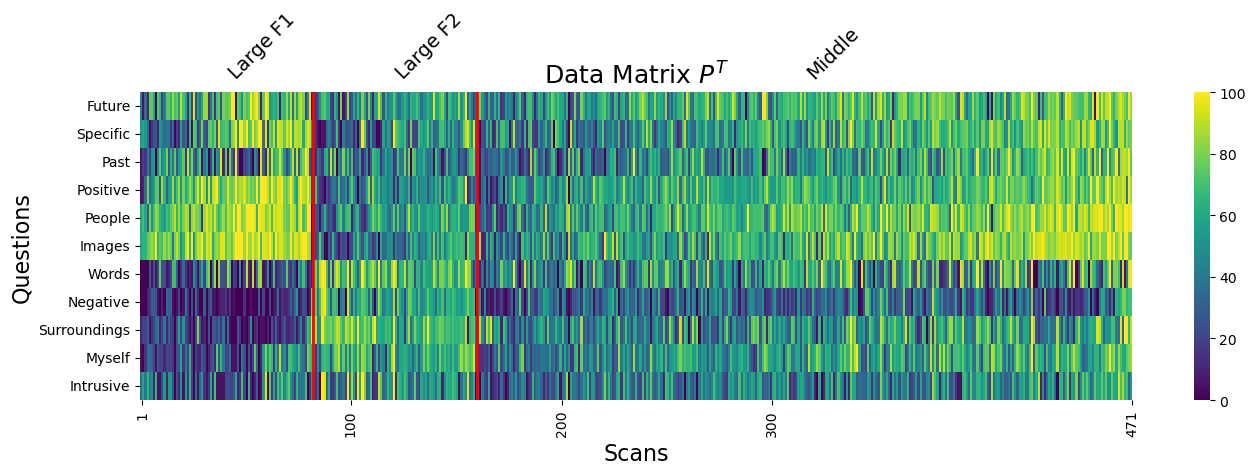

In [30]:
plot_P(M, question_order=q_order, scan_order=sort_clf1f2_idx, clusters_info=clusters_info)

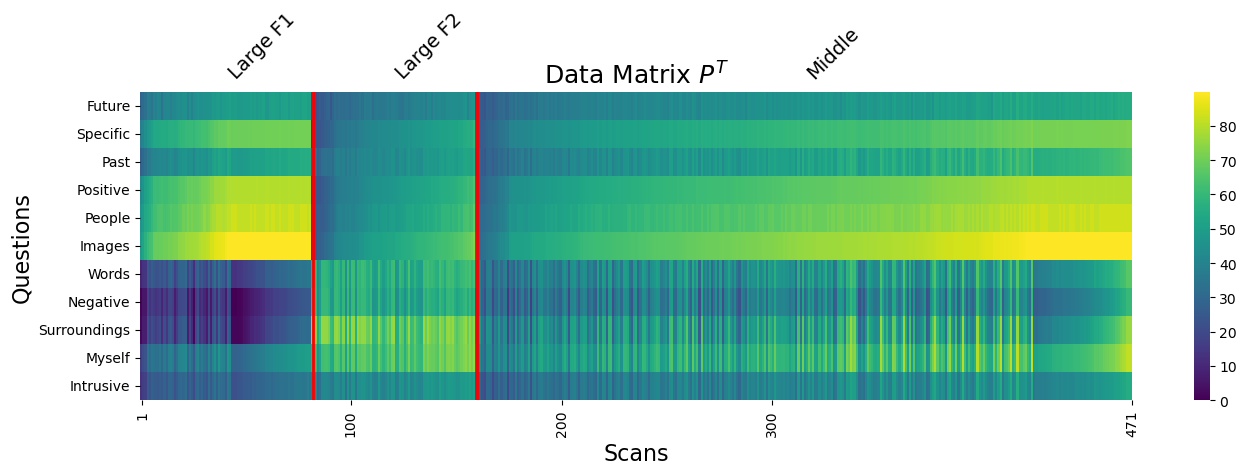

In [31]:
plot_P(Mrecon, question_order=q_order, scan_order=sort_clf1f2_idx, clusters_info=clusters_info)

In [32]:
out_path='../resources/mtl_snycq/SNYCQ_clusters_info.csv'
clusters_info.to_csv(out_path)
print('++ INFO: Clustering Membership Info saved to [%s]' % out_path)

++ INFO: Clustering Membership Info saved to [../resources/mtl_snycq/SNYCQ_clusters_info.csv]
